 # "СберАвтоподписка": разработка модели, предсказывающей целевое событие  

---

**Цель проекта**: разработать модель предсказания совершения одного из целевых действий ("Заказать звонок", "Оставить заявку") для сессий по введенным атрибутам типа utm_*, device_*, geo_* и упаковать модель в сервис.



**Целевая метрика**: ориентировочное значение roc-auc > 0.65 — факт совершения
пользователем целевого действия.

**Формат вывода ответа** - 0/1

**Скорость ответа сервиса** - не более 3 секунд

**Сервис** - это должен быть (минимум) - py-скрипт с инструкцией по запуску, (максимум) - localhost web app.

---

В данной работе я буду использовать библиотеку [Feature-engine](https://feature-engine.trainindata.com/en/latest/). Мы не рассматривали ее в настоящем курсе, однако, в процессе самостоятельного изучения аспектов создания моделей предсказания, я нашел ее очень интересным инструментом и решил изучить и использовать его на практике.

Вот небольшая характеристика Feature-engine:

* Feature-engine содержит наиболее исчерпывающую коллекцию преобразований для разработки функций.

* Feature-engine может преобразовывать определенную группу переменных в фрейм данных.

* Feature-engine возвращает кадры данных, поэтому подходит для исследования данных и развертывания модели.

* Feature-engine совместим с конвейером Scikit-learn, грид- и случайным поиском и перекрестной проверкой.

* Feature-engine автоматически распознает числовые, категориальные переменные и переменные даты и времени.

* Feature-engine предупреждает вас, если преобразование невозможно, например, если применяется логарифмирование к отрицательным переменным или деление на 0.




### Импорт библиотек

#### Перед импортом библиотек предварительно устанавливается:
* `pip install xgboost` согласно [документации](https://xgboost.readthedocs.io/en/stable/install.html#python)
* `pip install lightgbm` согласно [документации](https://github.com/microsoft/LightGBM/tree/master/python-package)
* `pip install bayesian-optimization` согласно [документации](https://github.com/fmfn/BayesianOptimization)
* `pip install feature-engine`
* `pip install bayesian-optimization`
* `pip install colorama`

In [194]:
import sys
from datetime import datetime
import warnings
from pathlib import Path
from typing import Union
from functools import partial


import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# препроцессинг и метрики
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, precision_score, 
    recall_score, f1_score, make_scorer, roc_curve)
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.outliers import Winsorizer
from feature_engine.selection import (
    DropDuplicateFeatures, DropConstantFeatures, 
    DropCorrelatedFeatures, DropFeatures)
from feature_engine.transformation import YeoJohnsonTransformer
from bayes_opt import BayesianOptimization

# модели
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, HistGradientBoostingClassifier)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# дополнительные данные
from additional_data import (
    get_distance_from_moscow, target_events, missing_values, organic_mediums, 
    social_media_sources, moscow_region_cities, big_cities, russian_holidays)

### Создание констант

In [195]:
# необходимо указать путь к папкам с данными и моделями

data_folder = Path('..', 'data')
models_folder = Path('.', 'models')

sessions_filename = 'ga_sessions.csv'
hits_filename = 'ga_hits.csv'

In [196]:
TEST_SIZE = 200_000
RANDOM_SEED = 0

### Настройка ноутбука

In [197]:
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

### Загрузка данных

Для файла `ga_hits.csv` нужно загрузить только колонки 'session_id' и 'event_action', так как остальные не используются.

In [198]:
sessions = pd.read_csv(data_folder / sessions_filename)
hits = pd.read_csv(data_folder / hits_filename, 
                   usecols=['session_id', 'event_action'])

In [199]:
sessions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 1.8 GB


In [200]:
hits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    object
 1   event_action  object
dtypes: object(2)
memory usage: 2.5 GB


## Подготовка данных

### Целевая переменная  

Целевая переменная считается положительной, если для сессии из `sessions` есть хотя бы одно целевое событие в `hits`. 

In [201]:
hits['target'] = hits['event_action'].isin(target_events) # заполняет столбец hits['target'] 'True', если hits['event_action'] содержит целевую
is_target_event = hits.groupby('session_id')['target'].any().astype(int) # target группирует по id (session_id) и по столбцу 'target', то есть все одинаковые session_id собираются

In [202]:
hits['target']

0           False
1           False
2           False
3           False
4           False
            ...  
15726465    False
15726466    False
15726467    False
15726468    False
15726469    False
Name: target, Length: 15726470, dtype: bool

In [203]:
is_target_event

session_id
1000009318903347362.1632663668.1632663668    0
1000010177899156286.1635013443.1635013443    0
1000013386240115915.1635402956.1635402956    0
1000017303238376207.1623489300.1623489300    0
1000020580299877109.1624943350.1624943350    0
                                            ..
999960188766601545.1626816843.1626816843     0
99996598443387715.1626811203.1626811203      0
999966717128502952.1638428330.1638428330     0
999988617151873171.1623556243.1623556243     0
999989480451054428.1634311006.1634311006     0
Name: target, Length: 1734610, dtype: int32

In [204]:
target = pd.Series(is_target_event, index=sessions['session_id']).fillna(0.0) # Заполним пропуски 0,0
target.value_counts(dropna=False, normalize=True) # посчитаем значения, так и есть - целевых значений  2,7%

0.0    0.97295
1.0    0.02705
Name: target, dtype: float64

In [205]:
target

session_id
9055434745589932991.1637753792.1637753792    0.0
905544597018549464.1636867290.1636867290     0.0
9055446045651783499.1640648526.1640648526    0.0
9055447046360770272.1622255328.1622255328    0.0
9055447046360770272.1622255345.1622255345    0.0
                                            ... 
9055415581448263752.1640159305.1640159305    0.0
9055421130527858185.1622007305.1622007305    0.0
9055422955903931195.1636979515.1636979515    0.0
905543020766873816.1638189404.1638189404     0.0
9055430416266113553.1640968742.1640968742    0.0
Name: target, Length: 1860042, dtype: float64

In [206]:
del hits # удалим датафрейм за ненадобностью чтобы не занимал много памяти

### Заполнение пропусков  

Пропуски в колонке `device_screen_resolution` заполняем самым частым значением.  
Все остальные пропуски в колонках заполняем значением '(nan)'.

In [207]:
def fill_missings(data: pd.DataFrame) -> pd.DataFrame:
    """Заполняет пропущенные значения:
    * самым частым значением для `device_screen_resolution`;
    * значением '(nan)' во всех остальных случаях.
    """

    data = data.copy()

    if 'device_screen_resolution' in data.columns:
        # '414x896' - самое частое значение в 'device_screen_resolution'
        # согласно предварительному анализу данных
        data['device_screen_resolution'] = \
            data['device_screen_resolution'].replace(missing_values, '414x896')
    
    return data.fillna('(nan)')

### Генерация признаков

Создаётся множество дополнительных переменных: день недели и день месяца, является ли день выходным, час и минута посещения, ночью ли посещение, ширина, высота, площадь и соотношение экрана.

В том числе с дополнительными данными: является ли день празничным, является ли трафик органическим, из социальных ли сетей он, находится ли пользователь в большом городе или в московской области, расстояние до Москвы как численно, так и в виде категорий.

In [208]:
def distance_category(distance: float) -> str:
    """Возвращает категорию расстояния до Москвы."""

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

In [209]:
def create_features(data: pd.DataFrame) -> pd.DataFrame:
    """Создаёт новые признаки из существующих."""

    data = data.copy()
    
    # visit_date признаки 
    if 'visit_date' in data.columns:
        data['visit_date'] = data['visit_date'].astype('datetime64[ns]')
        data['visit_date_added_holiday'] = \
            data['visit_date'].isin(russian_holidays)
        # числовые признаки сделаем строго положительными 
        # для лучшей обработки на шаге с YeoJohnsonTransformer
        data['visit_date_weekday'] = data['visit_date'].dt.weekday + 1
        data['visit_date_weekend'] = data['visit_date'].dt.weekday > 4
        data['visit_date_day'] = data['visit_date'].dt.day + 1

    # visit_time признаки
    if 'visit_time' in data.columns:
        data['visit_time'] = data['visit_time'].astype('datetime64[ns]')
        data['visit_time_hour'] = data['visit_time'].dt.hour + 1
        data['visit_time_minute'] = data['visit_time'].dt.minute + 1
        data['visit_time_night'] = data['visit_time'].dt.hour < 9

    # utm_* признаки
    if 'utm_medium' in data.columns:
        data['utm_medium_added_is_organic'] = \
            data['utm_medium'].isin(organic_mediums)
    if 'utm_source' in data.columns: 
        data['utm_source_added_is_social'] = \
            data['utm_source'].isin(social_media_sources)
    
    # device_screen признаки
    if 'device_screen_resolution' in data.columns:
        name = 'device_screen_resolution'
        data[[name + '_width', name + '_height']] = \
            data[name].str.split('x', expand=True).astype(float)
        data[name + '_area'] = data[name + '_width'] * data[name + '_height']
        data[name + '_ratio'] = data[name + '_width'] / data[name + '_height']
        data[name + '_ratio_greater_1'] = data[name + '_ratio'] > 1

    # geo_city признаки 
    if 'geo_city' in data.columns:
        data['geo_city_added_is_moscow_region'] = \
            data['geo_city'].isin(moscow_region_cities)
        data['geo_city_added_is_big'] = data['geo_city'].isin(big_cities)
        data['geo_city_is_big_or_in_moscow_region'] = \
            data['geo_city_added_is_moscow_region'] \
            | data['geo_city_added_is_big']
        data['geo_city_added_distance_from_moscow'] = \
            data['geo_city'].apply(get_distance_from_moscow)
        data['geo_city_added_distance_from_moscow_category'] = \
            data['geo_city_added_distance_from_moscow'].apply(distance_category)

    return data

### Дополнительно

In [210]:
def set_index(data: pd.DataFrame, column: str = 'session_id') -> pd.DataFrame:
    """Устанавливает в качестве индекса датафрейма колонку `column`."""
    
    data = data.copy()

    if column in data.columns:
        data = data.set_index(column)
    
    return data

In [211]:
def converse_types(data: pd.DataFrame) -> pd.DataFrame:
    """Приводит типы переменных к float. В первую очередь 
    необходимо для преобразования bool значений.
    """

    return data.astype(float)

### Собираем пайплайн  

Пайплайн по подготовке данных состоит из 4 частей:  
1. Создание дополнительных признаков
2. Преобразование численных переменных
3. Преобразование категориальных переменных
4. Удаление лишних признаков

In [212]:
preprocessor = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Приведение датафрейма к удобному виду 
    ('indexer', FunctionTransformer(set_index)), 
    ('imputer', FunctionTransformer(fill_missings)), 
    ('engineer', FunctionTransformer(create_features)), 
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                              'device_screen_resolution'])), 

    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 

    # Преобразования категориальных признаков
    ('rare_encoder', RareLabelEncoder(tol=0.05, replace_with='rare')), 
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
    ('bool_converter', FunctionTransformer(converse_types)), 

    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.99)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8)), 

])

## Моделирование

### Разделение данных  

Разделим данные на тренировочную, валидационную и тестовую выборки.  


In [213]:
X, X_test, y, y_test = train_test_split(
    sessions, target, test_size=TEST_SIZE, 
    stratify=target, random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, 
    stratify=y, random_state=RANDOM_SEED)

print(f'train shapes: {X_train.shape} {y_train.shape}')
print(f'valid shapes: {X_valid.shape} {y_valid.shape}')
print(f'test  shapes: {X_test.shape} {y_test.shape}')

train shapes: (1460042, 18) (1460042,)
valid shapes: (200000, 18) (200000,)
test  shapes: (200000, 18) (200000,)


### Препроцессинг данных  

Преобразуем тренировочные и валидационные данные с помощью построенного конвейера.

In [654]:
X_train

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
1056663,547332070992313735.1638727047.1638727047,127435678.163873,2021-12-05,20:57:27,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,428x926,Safari,Russia,Novotroitsk
1409550,7049980726847853060.1629809978.1629809978,1641451550.162934,2021-08-24,15:00:00,5,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,NaN,mobile,NaN,Xiaomi,NaN,393x851,Chrome,Russia,Balashikha
739873,4064566220882386809.1639930788.1639930788,946355569.163992,2021-12-19,19:19:48,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,339x753,Chrome,Russia,Almetyevsk
62902,1033849280328168809.1631647080.1631647080,240711793.163165,2021-09-14,22:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,414x896,Safari,Russia,Saint Petersburg
1297234,6544287746962620171.1638268683.1638268683,1523710728.163827,2021-11-30,13:38:03,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793000,8755082352522037809.1633552946.1633552946,2038451459.163355,2021-10-06,23:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x800,Chrome,Russia,Moscow
207261,1682284231298311525.1640424805.1640424805,391687320.1640424805,2021-12-25,12:33:25,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x812,Safari,Russia,Saint Petersburg
93412,1170303784354950884.1640345317.1640345317,272482583.164035,2021-12-24,14:28:37,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
1568591,7753976912353269271.1634047522.1634047522,1805363435.163405,2021-10-12,17:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Xiaomi,NaN,393x851,Chrome,Russia,Novosibirsk


In [214]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

print(f'X_train.shape = {X_train_preprocessed.shape}')

X_train.shape = (1460042, 55)


### Выбор метрик  

Будем использовать в качестве основной метрики - `roc_auc`. Но также взглянем и на другие метрики: `accuracy`, `precision`, `recall`, `f1`.  


In [215]:
def find_best_threshold(
    y_true: pd.Series, 
    y_proba: pd.Series, 
    metriс_name: str = 'roc_auc', 
    iterations: int = 250, 
    learning_rate: float = 0.05
) -> float:
    """Находит лучший порог перевода вероятностей `y_proba` 
    в принадлежность к классу 1.
    """
    
    # Получение функции метрики, которую оптимизируем
    metrics = {'roc_auc': roc_auc_score, 'f1': f1_score, 
               'precision': precision_score, 'recall': recall_score}
    metric_function = metrics.get(metriс_name, accuracy_score)

    # Получение метрики
    def get_metric(threshold: float) -> float:
        prediction = (y_proba > threshold).astype(int)
        return metric_function(y_true, prediction)

    direction = -1
    shift = 0.25

    best_threshold = 0.5
    best_metric = get_metric(best_threshold)

    # На каждой итерации
    for i in range(iterations):

        # Меняем порог
        threshold = best_threshold + direction * shift
        shift *= (1 - learning_rate)
        metric = get_metric(threshold)

        # И проверяем, улучшилась ли метрика
        if metric > best_metric: 
            best_threshold = threshold
            best_metric = metric
        else: 
            direction *= -1
            
    return best_threshold

In [216]:
def print_metrics(
    model: BaseEstimator, 
    X: pd.DataFrame, 
    y: pd.Series, 
    threshold: Union[float, None] = None, 
    show_roc_curve: bool = False
) -> None:
    """Получает метрики бинарной классификации из модели `model` на данных 
    `X` и `y`. Если возможно, то через метод `predict_proba` с заданным 
    порогом перевода вероятностей в классы `threshold`, иначе через `predict`. 
    Если `threshold` равен None, автоматически найдёт лучший порог.  
    ---
    Метрики: roc_auc, accuracy, precision, recall, f1, confusion_matrix, 
    roc_curve.
    """

    # Получим предсказания, если возможно в виде вероятностей
    try: 
        probas = model.predict_proba(X)[:, 1]
    except AttributeError:
        prediction = model.predict(X)
        threshold = None
        probas = None
    else:
        threshold = threshold or find_best_threshold(y, probas, 'roc_auc')
        prediction = (probas > threshold).astype(int)

    # Распечатаем порог перевода вероятностей в классы
    if threshold is None:
        print("Порог перевода вероятностей в классы: не используется")
    else:
        print(f"Порог перевода вероятностей в классы: {threshold}")
        print(f"{roc_auc_score(y, probas)} - roc_auc на вероятностях")

    # Распечатаем однострочные метрики
    print()
    print(f"{roc_auc_score(y, prediction):0.8f} - roc_auc")
    print(f"{accuracy_score(y, prediction):0.8f} - accuracy")
    print(f"{precision_score(y, prediction):0.8f} - precision")
    print(f"{recall_score(y, prediction):0.8f} - recall")
    print(f"{f1_score(y, prediction):0.8f} - f1")

    # Распечатаем матрицу ошибок
    conf_mat = confusion_matrix(y, prediction)
    classes = model.classes_
    n_classes = len(classes)
    print()
    print("|".join(f"{i:^10}" for i in ["prediction"] + list(classes)))
    print(f"{'true label':^10}" + ("|" + " " * 10) * n_classes)
    print("-" * ((n_classes * 10) + n_classes + 10))
    for i in range(n_classes):
        print("|".join(f"{j:>10}" for j in [classes[i]] + list(conf_mat[i])))

    # Отобразим ROC-кривую
    if show_roc_curve:
        print()
        plt.figure(figsize=(7, 4))
        if probas is not None:
            plt.plot(*roc_curve(y_test, probas)[:2], 
                     c='r', label='on probability')
        plt.plot(*roc_curve(y_test, prediction)[:2], c='b', label='on class')
        plt.plot([0, 1], [0, 1], c='y', label='random', linestyle='dashed')
        plt.title('Receiver operating characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

### Базовая модель  

Так как целевая переменная распределена не равномерно, то в качестве бейзлайна можно выбрать стратегию, которая для каждой сессии предсказывает значение 0.  


In [217]:
# Обучим базовую модель 
baseline = DummyClassifier(strategy='constant', constant=0)
baseline.fit(X_train_preprocessed, y_train)

# И получим её метрики
print_metrics(baseline, X_valid_preprocessed, y_valid, 0.5)

Порог перевода вероятностей в классы: 0.5
0.5 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


### Выбор модели  

Обучим несколько моделей, оценим на валидационной выборке и выберем лучшую, которую уже будем оптимизировать.

#### Логистическая регрессия

In [218]:
logreg = LogisticRegression(random_state=RANDOM_SEED)

In [219]:
%%time
logreg.fit(X_train_preprocessed, y_train);

Wall time: 11.1 s


LogisticRegression(random_state=0)

In [220]:
print_metrics(logreg, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.5
0.6683645332681568 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


#### Метод опорных векторов

In [221]:
svc = LinearSVC(class_weight='balanced')


In [222]:
%%time
svc.fit(X_train_preprocessed, y_train);

Wall time: 10min 29s


LinearSVC(class_weight='balanced')

In [223]:
print_metrics(svc, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: не используется

0.62056289 - roc_auc
0.61588500 - accuracy
0.04328417 - precision
0.62550832 - recall
0.08096565 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    119793|     74797
       1.0|      2026|      3384


#### Нейронная сеть

In [224]:
mlp = MLPClassifier((32,), random_state=RANDOM_SEED)

In [225]:
%%time
mlp.fit(X_train_preprocessed, y_train);

Wall time: 1min 9s


MLPClassifier(hidden_layer_sizes=(32,), random_state=0)

In [226]:
print_metrics(mlp, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.5
0.6983782119645087 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


In [227]:
from alive_progress import alive_bar
import time

for x in 1000, 1500, 700, 0:
   with alive_bar(x) as bar:
       for i in range(1000):
           time.sleep(.005)
           bar()

|████████████████████████████████████████| 1000/1000 [100%] in 15.6s (64.18/s) 
|██████████████████████████▋⚠︎            | (!) 1000/1500 [67%] in 15.6s (64.11/s) 
|████████████████████████████████████████✗︎ (!) 1000/700 [143%] in 15.6s (64.10/s) 
|████████████████████████████████████████| 1000 in 15.6s (64.16/s) 


#### Байесовский классификатор

In [228]:
gaussnb = GaussianNB()

In [229]:
%%time
gaussnb.fit(X_train_preprocessed, y_train);

Wall time: 1.33 s


GaussianNB()

In [230]:
print_metrics(gaussnb, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.05419511287276451
0.6458839691283222 - roc_auc на вероятностях

0.60928251 - roc_auc
0.56001500 - accuracy
0.03986940 - precision
0.66136784 - recall
0.07520520 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    108425|     86165
       1.0|      1832|      3578


#### Дерево решений

In [231]:
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

In [232]:
%%time
tree.fit(X_train_preprocessed, y_train);

Wall time: 26.7 s


DecisionTreeClassifier(random_state=0)

In [233]:
print_metrics(tree, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.033708156968674276
0.5204877305418407 - roc_auc на вероятностях

0.52080171 - roc_auc
0.93335000 - accuracy
0.05183341 - precision
0.08465804 - recall
0.06429875 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    186212|      8378
       1.0|      4952|       458


#### Случайный лес

In [234]:
forest = RandomForestClassifier(random_state=RANDOM_SEED)

In [235]:
%%time
forest.fit(X_train_preprocessed, y_train);

Wall time: 7min 3s


RandomForestClassifier(random_state=0)

In [236]:
print_metrics(forest, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.010218123817113232
0.6253519433580381 - roc_auc на вероятностях

0.59594638 - roc_auc
0.59998000 - accuracy
0.03952047 - precision
0.59168207 - recall
0.07409208 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    116795|     77795
       1.0|      2209|      3201


#### Градиентный Бустинг

In [237]:
histboost = HistGradientBoostingClassifier(random_state=RANDOM_SEED)

In [238]:
%%time
histboost.fit(X_train_preprocessed, y_train);

Wall time: 15.6 s


HistGradientBoostingClassifier(random_state=0)

In [239]:
print_metrics(histboost, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.02822602984682529
0.70696812360298 - roc_auc на вероятностях

0.64682393 - roc_auc
0.62957000 - accuracy
0.04742197 - precision
0.66506470 - recall
0.08853129 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    122316|     72274
       1.0|      1812|      3598


#### [CatBoost](https://catboost.ai/) (CatBoost - открытая программная библиотека, разработанная компанией Яндекс и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга.)

In [240]:
catboost = CatBoostClassifier(
    iterations=100, verbose=False, random_state=RANDOM_SEED)

In [241]:
%%time
catboost.fit(X_train_preprocessed, y_train);

Wall time: 10.8 s


In [242]:
print_metrics(catboost, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.02533905564192846
0.7068194537469606 - roc_auc на вероятностях

0.64895457 - roc_auc
0.58476000 - accuracy
0.04541303 - precision
0.71682070 - recall
0.08541474 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    113074|     81516
       1.0|      1532|      3878


#### [XGBoost](https://github.com/dmlc/xgboost)

Основные особенности XGBoost, отличающие его от других алгоритмов градиентного бустинга, включают:

* Умная штрафовка деревьев
* Пропорциональное уменьшение узлов листьев
* Метод Ньютона в оптимизации
* Дополнительный параметр рандомизации
* Реализация на одиночных, распределенных системах и out-of-core вычислениях
* Автоматический отбор признаков

Предварительно устанавливается `pip install xgboost` согласно [документации](https://xgboost.readthedocs.io/en/stable/install.html#python)

In [243]:
xgboost = XGBClassifier()

In [244]:
%%time
xgboost.fit(X_train_preprocessed.values, y_train.values);

Wall time: 1min 14s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [245]:
print_metrics(xgboost, X_valid_preprocessed.values, y_valid.values)

Порог перевода вероятностей в классы: 0.02784477629170188
0.7107721766577036 - roc_auc на вероятностях

0.65178082 - roc_auc
0.63432000 - accuracy
0.04836085 - precision
0.67024030 - recall
0.09021247 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    123238|     71352
       1.0|      1784|      3626


#### LGBMClassifier — это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом.

In [246]:
lightgbm = LGBMClassifier(random_state=RANDOM_SEED)

In [247]:
%%time
lightgbm.fit(X_train_preprocessed, y_train);

Wall time: 4.62 s


LGBMClassifier(random_state=0)

In [248]:
print_metrics(lightgbm, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.028516118176763625
0.7069700438449713 - roc_auc на вероятностях

0.64701144 - roc_auc
0.63535500 - accuracy
0.04778107 - precision
0.65933457 - recall
0.08910483 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    123504|     71086
       1.0|      1843|      3567


### Оптимизация модели  

Лучшей моделью является LightGBM по следующим причинам:
+ Один из лучших показателей `roc_auc`.
+ Быстрое обучение. 
+ Модель интерпретируема, то есть можно получить показатели важности признаков.
+ Может предсказывать вероятность класса.
+ Нет проблем с процессорами без SSE4 как у CatBoost.

Оптимизация модели и конвейера по подготовке данных проводится с помощью байесовской оптимизации. При разных гиперпараметрах модель обучается на тренировочных данных, а оценивается на валидационных.

In [249]:
def optimize_lightgbm(
    rare_encoder_tol: float, 
    constant_dropper_tol: float, 
    correlated_dropper_threshold: float, 
    n_estimators: float, 
    learning_rate: float, 
    reg_lambda: float, 
    num_leaves: float, 
    reg_alpha: float, 
    boosting_type: str = 'goss'
) -> float:
    """Используется Баейсовским оптимизатором для поиска лучших гиперпараметров 
    конвейера по подготовке данных и модели LGBMClassifier.
    """

    # Создадим конвейер с заданными гиперпараметрами
    model = Pipeline(steps=[
        # Создание дополнительных признаков
        ('indexer', FunctionTransformer(set_index)), 
        ('imputer', FunctionTransformer(fill_missings)), 
        ('engineer', FunctionTransformer(create_features)), 
        ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                                  'device_screen_resolution'])), 
        # Преобразования численных переменных
        ('normalization', YeoJohnsonTransformer()), 
        ('outlier_remover', Winsorizer()), 
        ('scaler', SklearnTransformerWrapper(StandardScaler())), 
        # Преобразования категориальных признаков
        ('rare_encoder', RareLabelEncoder(
            tol=rare_encoder_tol, replace_with='rare')),
        ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
        ('bool_converter', FunctionTransformer(converse_types)), 
        # Удаление дубликатов и коррелируемых признаков
        ('constant_dropper', DropConstantFeatures(tol=constant_dropper_tol)), 
        ('duplicated_dropper', DropDuplicateFeatures()), 
        ('correlated_dropper', DropCorrelatedFeatures(
            threshold=correlated_dropper_threshold)), 
        # Лучшая модель с оптимизированными гиперпараметрами
        ('model', LGBMClassifier(
            n_estimators=int(n_estimators), boosting_type=boosting_type, 
            learning_rate=learning_rate, num_leaves=int(num_leaves), 
            reg_lambda=reg_lambda, reg_alpha=reg_alpha, 
            random_state=RANDOM_SEED))])
    
    # Обучим и оценим модель
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, prediction)

In [539]:
X_train

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
1056663,547332070992313735.1638727047.1638727047,127435678.163873,2021-12-05,20:57:27,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,428x926,Safari,Russia,Novotroitsk
1409550,7049980726847853060.1629809978.1629809978,1641451550.162934,2021-08-24,15:00:00,5,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,NaN,mobile,NaN,Xiaomi,NaN,393x851,Chrome,Russia,Balashikha
739873,4064566220882386809.1639930788.1639930788,946355569.163992,2021-12-19,19:19:48,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,339x753,Chrome,Russia,Almetyevsk
62902,1033849280328168809.1631647080.1631647080,240711793.163165,2021-09-14,22:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,414x896,Safari,Russia,Saint Petersburg
1297234,6544287746962620171.1638268683.1638268683,1523710728.163827,2021-11-30,13:38:03,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793000,8755082352522037809.1633552946.1633552946,2038451459.163355,2021-10-06,23:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x800,Chrome,Russia,Moscow
207261,1682284231298311525.1640424805.1640424805,391687320.1640424805,2021-12-25,12:33:25,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x812,Safari,Russia,Saint Petersburg
93412,1170303784354950884.1640345317.1640345317,272482583.164035,2021-12-24,14:28:37,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
1568591,7753976912353269271.1634047522.1634047522,1805363435.163405,2021-10-12,17:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Xiaomi,NaN,393x851,Chrome,Russia,Novosibirsk


In [250]:
optimizing_parameters = {
    'rare_encoder_tol': (0.01, 0.1), 
    'constant_dropper_tol': (0.95, 0.999), 
    'correlated_dropper_threshold': (0.7, 0.99), 
    'n_estimators': (50, 5000), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50), 
    'num_leaves': (10, 120), 
    'reg_alpha': (0, 50)}

In [251]:
# байесовский оптимизатор не работает с категориальными значениями, поэтому для 
# каждого типа бустинга будет проводится своя оптимизация гиперпараметров

best_score, best_parameters = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer = BayesianOptimization(
        partial(optimize_lightgbm, boosting_type=boosting_type), 
        optimizing_parameters, random_state=RANDOM_SEED)
    optimizer.maximize(init_points=5, n_iter=10)
    
    if best_score < optimizer.max['target']:
        best_score = optimizer.max['target']
        best_parameters.update(optimizer.max['params'])
        best_parameters['boosting_type'] = boosting_type

boosting_type = gbdt
|   iter    |  target   | consta... | correl... | learni... | n_esti... | num_le... | rare_e... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7107    | 0.9769    | 0.9074    | 0.1547    | 2.747e+03 | 56.6      | 0.06813   | 21.88     | 44.59     |
| 2         | 0.6836    | 0.9972    | 0.8112    | 0.2       | 2.668e+03 | 72.48     | 0.0933    | 3.552     | 4.356     |
| 3         | 0.7094    | 0.951     | 0.9415    | 0.1968    | 4.357e+03 | 117.6     | 0.08192   | 23.07     | 39.03     |
| 4         | 0.7113    | 0.9558    | 0.8856    | 0.0444    | 4.726e+03 | 67.4      | 0.04732   | 13.23     | 38.71     |
| 5         | 0.7055    | 0.9724    | 0.8648    | 0.01451   | 3.107e+03 | 77.33     | 0.06552   | 47.19     | 34.09     |
| 6         | 0.7087    | 0.9859    | 0.7406    | 0.07166   | 4.72e+03  | 61.15     | 0.06792   | 12.79     | 47.99     |
| 7

In [252]:
print(f'Лучшее значение метрики ROC-AUC={best_score} при параметрах:\n')
for param, value in best_parameters.items():
    print(f'{param} = {value}')

Лучшее значение метрики ROC-AUC=0.711314521294548 при параметрах:

constant_dropper_tol = 0.9557954468675777
correlated_dropper_threshold = 0.8855770961849819
learning_rate = 0.044404788978171135
n_estimators = 4726.111139395441
num_leaves = 67.40331539250789
rare_encoder_tol = 0.04731957459914713
reg_alpha = 13.227780605231349
reg_lambda = 38.71168447171083
boosting_type = gbdt


## Оценка модели

In [253]:
final_pipeline = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Приведение датафрейма к удобному виду 
    ('indexer', FunctionTransformer(set_index)), 
    ('imputer', FunctionTransformer(fill_missings)), 
    ('engineer', FunctionTransformer(create_features)), 
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                              'device_screen_resolution'])), 

    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 

    # Преобразования категориальных признаков
    ('rare_encoder', RareLabelEncoder(tol=0.047319, replace_with='rare')),
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
    ('bool_converter', FunctionTransformer(converse_types)), 

    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.95579)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8856)), 

    # Лучшая модель с оптимизированными гиперпараметрами
    ('model', LGBMClassifier(
        random_state=RANDOM_SEED, learning_rate=0.04440, boosting_type='gbdt', 
        n_estimators=4726, reg_lambda=38.7116, reg_alpha=13.22778, num_leaves=67)), 
    
])

### Метрики модели

Для оценки метрик модели обучим её на объектах тренировочной и валидационной выборках и сделаем предсказания на тестовых данных. 

Целевая метрика `roc-auc=0.6534` (для пресказанных классов) выбранной модели превосходит 0.65, а значит, цель работы выполнена.

Хотя метрика `f1=0.0849` довольно низкая, что неудивительно при большом количестве неверно классифицированных объектов нулевого класса.

У модели наблюдается совсем небольшое переобучение.

In [254]:
final_pipeline.fit(X, y);

In [255]:
test_proba = final_pipeline.predict_proba(X_test)[:, 1]
best_threshold = find_best_threshold(y_test, test_proba)
test_prediction = (test_proba > best_threshold).astype(int)

print(f'Лучший порог перевода вероятностей в класс: {best_threshold}')

Лучший порог перевода вероятностей в класс: 0.025970171560173425


In [256]:
print(f'Метрики лучшей модели на обучающей выборке:')
print_metrics(final_pipeline, X, y, best_threshold)

Метрики лучшей модели на обучающей выборке:
Порог перевода вероятностей в классы: 0.025970171560173425
0.7733082958232637 - roc_auc на вероятностях

0.69832994 - roc_auc
0.61846869 - accuracy
0.05335695 - precision
0.78275877 - recall
0.09990393 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    991535|    623603
       1.0|      9755|     35149


Метрики лучшей модели на тестовой выборке:
Порог перевода вероятностей в классы: 0.025970171560173425
0.7138627470108961 - roc_auc на вероятностях

0.65279266 - roc_auc
0.61286000 - accuracy
0.04727300 - precision
0.69500924 - recall
0.08852474 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    118812|     75778
       1.0|      1650|      3760



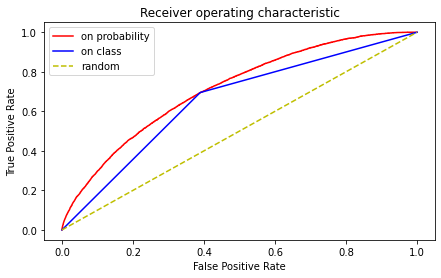

In [257]:
print(f'Метрики лучшей модели на тестовой выборке:')
print_metrics(
    final_pipeline, X_test, y_test, best_threshold, show_roc_curve=True)

### Обучение на всех данных

Для анализа обработки данных и важности признаков разобъём финальный конвейер на препроцессор и модель и обучим их на всех данных. А перед сохранением модели объединим обратно.

In [258]:
final_model = final_pipeline.named_steps['model']
final_preprocessor = final_pipeline.set_params(model=None)

In [259]:
sessions_preprocessed = final_preprocessor.fit_transform(sessions)

In [260]:
final_model.fit(sessions_preprocessed, target);

### Анализ обработки данных

В итоге всех преобразований получается 62 признака, при том, что ещё 16 признаков были удалены из-за корреляций и т.п..

Датасет имеет 175 034 дубликатов, но как показали эксперименты, удаление дубликатов из тренировочной выборки ведёт к небольшому ухудшению метрик. 

Признаков, коррелируемых с целевой переменной, нет.

In [540]:
sessions_preprocessed.shape

(1860042, 58)

In [262]:
sessions_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860042 entries, 9055434745589932991.1637753792.1637753792 to 9055430416266113553.1640968742.1640968742
Data columns (total 58 columns):
 #   Column                                                     Dtype  
---  ------                                                     -----  
 0   visit_number                                               float64
 1   visit_date_weekday                                         float64
 2   visit_date_weekend                                         float64
 3   visit_date_day                                             float64
 4   visit_time_hour                                            float64
 5   visit_time_minute                                          float64
 6   visit_time_night                                           float64
 7   utm_medium_added_is_organic                                float64
 8   utm_source_added_is_social                                 float64
 9   device_screen_resolut

In [263]:
print('Количество дубликатов:', sessions_preprocessed.duplicated().sum())

Количество дубликатов: 176667


In [264]:
print('Корреляция с целевой переменной:')
correlation = pd.concat([sessions_preprocessed, target], axis=1).corr()
correlation['target'].sort_values(ascending=False, key=abs).head(5)

Корреляция с целевой переменной:


target                                1.000000
utm_medium_added_is_organic           0.050813
utm_medium_referral                   0.049207
utm_adcontent_JNHcPlZPxEMWDnRiyoBf    0.044788
utm_source_bByPQxmDaMXgpHeypKSM       0.040561
Name: target, dtype: float64

### Важность признаков

Самыми важными признаками после преобразования оказались численные переменные: день (месяца и недели), час, минута (скорее всего именно нулевая минута часа) и номер посещения, размеры экрана и расстояние до Москвы.

После этих признаков важность остальных сильно падает. Возможно такова особенность работы с категориальными признаками (особенно с большим количеством неравномерно распределенных уникальных значений).

Самыми важными исходными признаками окзаались: размеры экрана, дата, время и номер посещения, город пользователя, а также признаки с дополнительными данными (как индикатор органического трафика). 

In [265]:
print('Признаки, удалённые во время feature selection\n')
all = 0

for step in ('constant_dropper', 'duplicated_dropper', 'correlated_dropper'):
    print(step + ':')
    for column in final_preprocessor.named_steps[step].features_to_drop_:
        print(f'\t{column}')
        all += 1

print(f'Всего удалено: {all}')

Признаки, удалённые во время feature selection

constant_dropper:
	visit_date_added_holiday
	device_screen_resolution_area
	device_category_tablet
	device_os_rare
	device_model_(nan)
	geo_country_Russia
	geo_city_added_distance_from_moscow_category_>= 3000 km
duplicated_dropper:
	geo_city_added_distance_from_moscow_category_moscow
	utm_medium_(none)
correlated_dropper:
	utm_keyword_(nan)
	utm_campaign_FTjNLDyTrXaWYgZymFkV
	device_category_desktop
	geo_city_added_distance_from_moscow_category_< 100 km
	device_os_(nan)
	device_brand_(nan)
	utm_campaign_LTuZkdKfxRGVceoWkVyg
	utm_medium_banner
	device_screen_resolution_ratio_greater_1
Всего удалено: 18


In [266]:
feature_importance = pd.Series(
    data=final_model.feature_importances_, 
    index=sessions_preprocessed.columns)

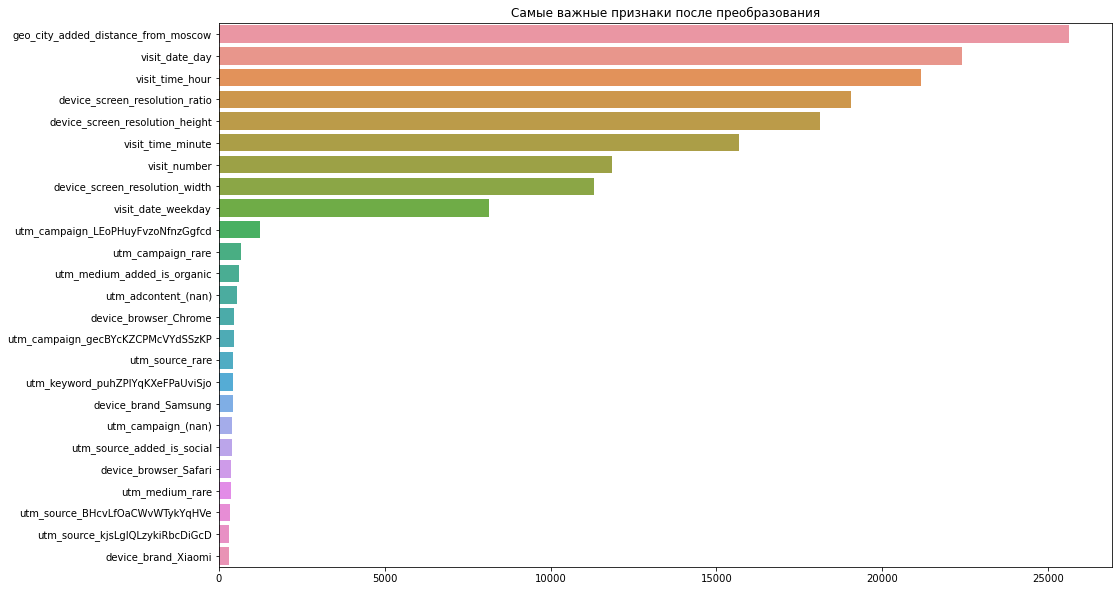

In [267]:
plt.figure(figsize=(16, 10))
most_important = feature_importance.sort_values(ascending=False).head(25)
sns.barplot(x=most_important, y=most_important.index, orient='h')
plt.title('Самые важные признаки после преобразования');

In [268]:
# Из важности производных признаков получим важность оригинальных
# Также получим важность признаков с добавленными данными '_added_'

original_columns = list(sessions.columns) + ['_added_']
column_importances = list()
for col in original_columns:
    imp = feature_importance[feature_importance.index.str.contains(col)].sum()
    column_importances.append(imp)

column_importances = pd.Series(column_importances, index=original_columns)
column_importances.sort_values(ascending=False, inplace=True)

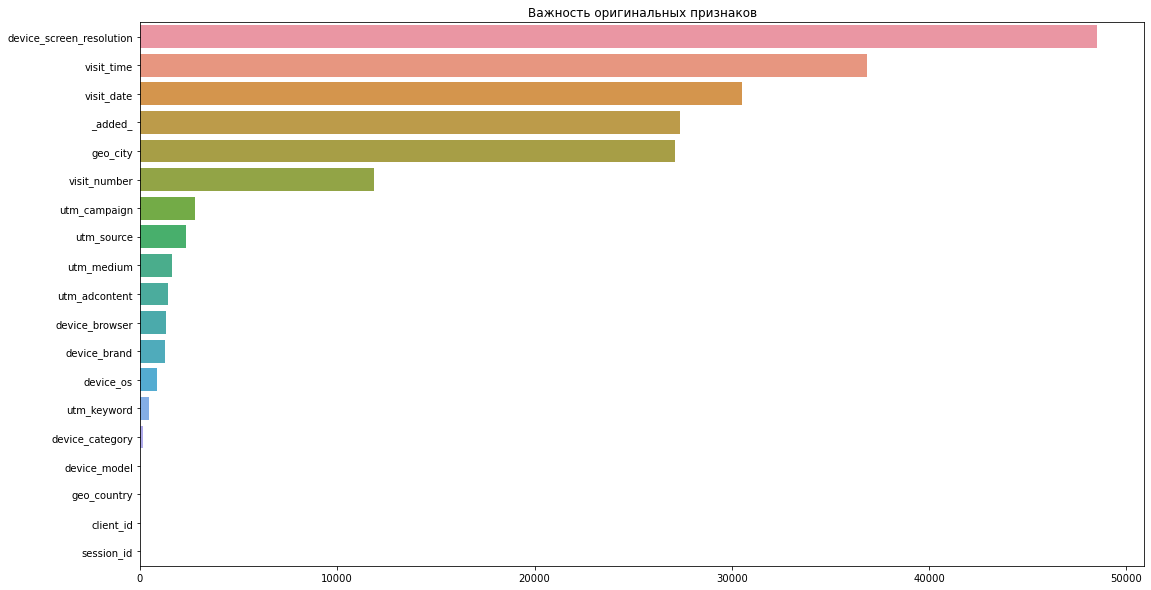

In [269]:
plt.figure(figsize=(18, 10))
sns.barplot(x=column_importances, y=column_importances.index, orient='h')
plt.title('Важность оригинальных признаков');

### Сохранение модели

In [589]:
# Объединим препроцессор и модель обратно

final_pipeline = final_preprocessor.set_params(model=final_model)

In [591]:
# Добавим метаданные для модели

metadata = {
    'name': 'SberAutopodpiska: target event prediction', 
    'descripton': ('Модель по предсказанию совершения пользователем одного из '
                   'целевых действий "Заказать звонок" или "Оставить заявку" '
                   'на сайте сервиса СберАвтоподписка.'), 
    'model_type': final_model.__class__.__name__, 
    'version': 1.1, 
    'training_datetime': datetime.now(), 
    'author': 'Demir Uzun', 
    'threshold': best_threshold, 
    'metrics': {
        'roc_auc': roc_auc_score(y_test, test_proba), 
        'roc_auc_by_class': roc_auc_score(y_test, test_prediction),
        'accuracy': accuracy_score(y_test, test_prediction), 
        'precision': precision_score(y_test, test_prediction), 
        'recall': recall_score(y_test, test_prediction), 
        'f1': f1_score(y_test, test_prediction),
    }
}

final_pipeline.metadata = metadata

In [592]:
# Сохраним модель

models_folder.mkdir(exist_ok=True)
filename = f'model_{datetime.now():%Y%m%d%H%M%S}.pkl'

with open(models_folder / filename, 'wb') as file:
    dill.dump(final_pipeline, file)

## Выводы

Для преобразования входных данных, со структурой как в файле `ga_sessions.csv`, в удобный для предсказания вид понадобилось четыре этапа:
1. Заполнение пропусков и генерация признаков. В том числе добавление новых данных, как-то органический трафик или расстояние до Москвы.
2. Преобразование численных переменных: нормализация и удаление выбросов.
3. Преобразование категориальных признаков. Основная сложность с ними была в многообразии редких уникальных значений. В итоге только самые популярные значения были закодированы методом one-hot.
4. Удаление дублирующих и коррелируемых признаков. Признаки могут коррелировать до 0.95, но именно с таким порогом финальная модель даёт лучший результат.

Было проверено 10 моделей с гиперпараметрами по умолчанию. В тройке лучших оказались алгоритмы бустинга от sklearn, lightgbm и catboost.

В итоге в качестве лучшей модели был выбран `LightGBM` по следующим причинам: 
+ Один из лучших показателей `roc_auc`.
+ Быстрое обучение. 
+ Модель интерпретируема, то есть можно получить показатели важности признаков.
+ Может предсказывать вероятность класса.
+ Нет проблем с процессорами без SSE4 как у CatBoost.

Шаг оптимизации модели помог выбрать лучшие гиперпараметры для модели: n_estimators=800, learning_rate=0.07, reg_lambda=10, num_leaves=26, reg_alpha=10, boosting_type='goss'.

Качество модели по метрике `roc-auc` составляет **0.7148** (0.6535 при предсказании классов). Но метрика `f1`=0.0871 оставляет желать лучшего. Тем не менее, переобучения нет и цель проекта выполнена - `roc-auc` > 0.65.

Для улучшения качества предсказания можно было бы: 
1. Увеличить количество данных. Тестовая выборка пойдёт на дообучение модели, так что может модель будет лучше в конечном итоге.
2. Провести ребалансировку классов. Но если уменьшить выборку с отрицательной целевой переменной, то модель теряет в качестве, а если увеличивать выборку с положительным классом, то модели обучаются слишком долго. 
3. Провести более тщательный поиск наилучших гиперпараметров - это займёт много времени, а прирост качества будет небольшим. 
4. Провести дополнительную генерацию признаков. Но хорошие идеи придумывать сложно.
5. Попробовать более сложные модели, например, нейронные сети глубокого обучения. 

In [593]:
import json


In [622]:
with open('data/exemples/examples.json', 'rb') as file:
    examples = json.load(file)

In [623]:
print('Запрос предсказания класса для одного объекта.')
data = json.dumps(examples[0])#.encode("utf-8")

Запрос предсказания класса для одного объекта.


In [655]:
#df = pd.DataFrame.from_dict([examples[0]])
df = pd.DataFrame.from_dict(examples)

In [657]:
df.shape

(5, 18)

In [625]:
y = model['model'].predict_proba(data)[:, 1]

ValueError: Expected 2D array, got scalar array instead:
array={"session_id": "905544597018549464.1636867290.1636867290", "client_id": "210838531.1636867225", "visit_date": "2021-11-14", "visit_time": "08:21:30", "visit_number": 1, "utm_source": "MvfHsxITijuriZxsqZqt", "utm_medium": "cpm", "utm_campaign": "FTjNLDyTrXaWYgZymFkV", "utm_adcontent": "xhoenQgDQsgfEPYNPwKO", "utm_keyword": "IGUCNvHlhfHpROGclCit", "device_category": "mobile", "device_os": "Android", "device_brand": "Samsung", "device_model": null, "device_screen_resolution": "385x854", "device_browser": "Samsung Internet", "geo_country": "Russia", "geo_city": "Moscow"}.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [627]:
data.reshape(-1, 1)

AttributeError: 'str' object has no attribute 'reshape'

In [629]:
my_pipi = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Приведение датафрейма к удобному виду 
    ('indexer', FunctionTransformer(set_index)), 
    ('imputer', FunctionTransformer(fill_missings)), 
    ('engineer', FunctionTransformer(create_features)), 
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                              'device_screen_resolution'])), 

    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 

    # Преобразования категориальных признаков
    ('rare_encoder', RareLabelEncoder(tol=0.047319, replace_with='rare')),
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
    ('bool_converter', FunctionTransformer(converse_types)), 

    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.95579)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8856)), 

    # # Лучшая модель с оптимизированными гиперпараметрами
    # ('model', LGBMClassifier(
    #     random_state=RANDOM_SEED, learning_rate=0.04440, boosting_type='gbdt', 
    #     n_estimators=4726, reg_lambda=38.7116, reg_alpha=13.22778, num_leaves=67)), 
    
])

In [630]:
my_pipi

Pipeline(steps=[('indexer',
                 FunctionTransformer(func=<function set_index at 0x0000020CF5CC4940>)),
                ('imputer',
                 FunctionTransformer(func=<function fill_missings at 0x0000020CF5CC4040>)),
                ('engineer',
                 FunctionTransformer(func=<function create_features at 0x0000020CCAA9D4C0>)),
                ('dropper',
                 DropFeatures(features_to_drop=['client_id', 'visit_date',
                                                'visit_time',
                                                'device_s...
                 RareLabelEncoder(replace_with='rare', tol=0.047319)),
                ('onehot_encoder', OneHotEncoder(drop_last_binary=True)),
                ('bool_converter',
                 FunctionTransformer(func=<function converse_types at 0x0000020CF5CC4D30>)),
                ('constant_dropper', DropConstantFeatures(tol=0.95579)),
                ('duplicated_dropper', DropDuplicateFeatures()),
                ('correlated_dropper',
                 DropCorrelatedFeatures(threshold=0.8856))])

In [645]:
d = my_pipi.fit(df)

ValueError: The resulting dataframe will have no columns after dropping all constant or quasi-constant features. Try changing the tol value.

In [646]:
d

NameError: name 'd' is not defined

In [664]:
wwwwww = df.iloc[[0]]

In [665]:
wwwwww

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,905544597018549464.1636867290.1636867290,210838531.1636867225,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,None,385x854,Samsung Internet,Russia,Moscow


In [668]:
we = preprocessor.fit_transform(df)
# we3 = preprocessor.transform(df)

# print(f'X_train.shape = {we.shape}')

In [669]:
we

,visit_number,visit_date_weekday,visit_date_weekend,visit_date_day,visit_time_hour,visit_time_minute,utm_medium_added_is_organic,device_screen_resolution_width,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_campaign_LEoPHuyFvzoNfnzGgfcd
session_id,,,,,,,,,,
905544597018549464.1636867290.1636867290,-0.5,1.332099,1.0,-0.466530,-0.365225,0.398810,0.0,0.422743,0.0,0.0
9055446045651783499.1640648526.1640648526,-0.5,-0.174235,0.0,0.861966,-1.625726,1.061528,0.0,-0.431235,1.0,1.0
9055447192389856083.1622453074.1622453074,-0.5,-1.062745,0.0,1.151198,0.862834,-1.194269,1.0,0.065987,0.0,0.0
9055466554104774132.1629442326.1629442326,2.0,0.967626,0.0,0.097909,-0.085101,-1.194269,0.0,1.492653,1.0,1.0
9055488359664698205.1635763037.1635763037,-0.5,-1.062745,0.0,-1.644543,1.213219,0.928199,0.0,-1.550147,1.0,0.0
